In [1]:
import h5py
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.manifold._t_sne")

import time

import itertools
#import torch
#from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# import torch
# import torch.nn as nn
# import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split, Dataset
#from torch.utils.data import DataLoader
#import numpy as np
#import itertools

import os
import pickle
import glob

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.io import loadmat

from model import LGN2V1
from utils import Utils as u
from train import TripletDataset

# SK refactored
Moved all of this code into scripts (`train.py`, `utils.py`, `model.py`) for ease of running on the cluster. Run `train.py` to recreate these results.

In [24]:
file_path = "/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/digits/"
model_path = "/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/models"

In [7]:
# Set file path and variable name (adjust as needed)
data_name = "triplet_digits_2"
mat_path = file_path + data_name + ".mat"
#mat_path = file_path + "allPatches.mat"
#mat_key = "allPatches"
mat_key = "triplets"
mat_lab = "labels"


In [8]:
v7 = 1

if v7 == 1:
    # --- Load from MATLAB v7 (non-HDF5) ---
    mat = loadmat(mat_path)  # mat_path is your .mat file
    raw = mat[mat_key]       # mat_key is the variable name inside the .mat file
    print("Raw MAT shape:", raw.shape)
    data = raw  # no transpose if shape is already correct
    
    labels = mat["labels"]
else:
    # Load from HDF5
    with h5py.File(mat_path, 'r') as f:
        raw = f[mat_key]
        print("Raw HDF5 shape:", raw.shape)
        data = np.array(raw)  # this ensures a clean ndarray
        
print(data.shape)

# Transpose
data = data.transpose(3, 2, 0, 1)
    
# --- Convert to float32 Torch tensor ---
triplet_data = torch.tensor(data).float() / 255.0

# Compute dataset mean & std once:
mean = triplet_data.mean()
std = triplet_data.std()

# Normalize entire dataset:
triplet_data = (triplet_data - mean) / std

print("Triplet_data shape:", triplet_data.shape)
print("Labels:", labels.shape)

Raw MAT shape: (16, 16, 3, 100000)
(16, 16, 3, 100000)
Triplet_data shape: torch.Size([100000, 3, 16, 16])
Labels: (1, 100000)


In [9]:
labels.shape

(1, 100000)

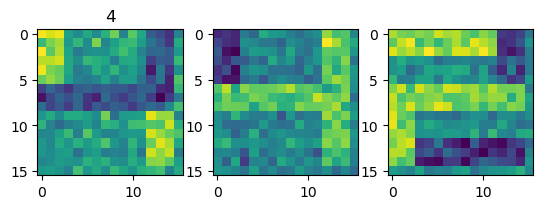

In [10]:
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.imshow(triplet_data[0,ii,:,:].detach().cpu().numpy())
    if ii == 0:
        plt.title(labels[0,0])

In [11]:
# Extract anchor, positive, and negative from the triplet tensor
anchor   = triplet_data[:, 0, :, :]
positive = triplet_data[:, 1, :, :]
negative = triplet_data[:, 2, :, :]

# Flatten images into vectors
a = anchor.reshape(anchor.size(0), -1)
p = positive.reshape(positive.size(0), -1)
n = negative.reshape(negative.size(0), -1)

# Compute distances
ap_dist = F.pairwise_distance(a, p)
an_dist = F.pairwise_distance(a, n)

# Compute margin violations
margin = 4.
violations = (ap_dist + margin > an_dist).float()

# Compute stats
mean_ap = ap_dist.mean().item()
mean_an = an_dist.mean().item()
violation_rate = violations.mean().item()

# Print results
print("Triplet Margin Stats:")
print(f"  Mean anchor-positive distance: {mean_ap:.4f}")
print(f"  Mean anchor-negative distance: {mean_an:.4f}")
print(f"  % Triplets violating margin ({margin}): {violation_rate * 100:.2f}%")

Triplet Margin Stats:
  Mean anchor-positive distance: 21.6915
  Mean anchor-negative distance: 22.1980
  % Triplets violating margin (4.0): 69.74%


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Assume triplet_data is a tensor of shape (N, 3, H, W)
# Convert to numpy if needed
X_np = triplet_data.numpy() if isinstance(triplet_data, torch.Tensor) else triplet_data

# Extract positives and negatives
positives = X_np[:, 1].reshape(X_np.shape[0], -1)  # shape: (N, H*W)
negatives = X_np[:, 2].reshape(X_np.shape[0], -1)

# Stack data and labels
X = np.vstack([positives, negatives])  # shape: (2N, H*W)
y = np.hstack([np.ones(len(positives)), np.zeros(len(negatives))])  # shape: (2N,)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_score)

print(f"🔍 Logistic Regression Accuracy: {acc:.4f}")
print(f"📈 ROC AUC Score: {auc:.4f}")

🔍 Logistic Regression Accuracy: 0.5020
📈 ROC AUC Score: 0.5015


In [13]:
def gini_index(x):
    x = np.array(x, dtype=np.float64)
    if np.amin(x) < 0:
        raise ValueError("Gini index is only defined for non-negative values")
    if np.all(x == 0):
        return 0.0  # Convention: Gini is 0 for uniform zero vector

    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x_sorted) / np.sum(x)) / n - (n + 1) / n

In [14]:
def compute_triplet_margin_stats(model, dataloader, device, margin=0.2):

    model.eval()
    ap_dists = []
    an_dists = []
    violations = []

    with torch.no_grad():
        for a, p, n in dataloader:
            a, p, n = a.to(device), p.to(device), n.to(device)

            anchor = model(a)
            positive = model(p)
            negative = model(n)

            ap = F.pairwise_distance(anchor, positive)
            an = F.pairwise_distance(anchor, negative)

            ap_dists.append(ap)
            an_dists.append(an)
            violations.append((ap + margin > an).float())

    ap_dists = torch.cat(ap_dists)
    an_dists = torch.cat(an_dists)
    violations = torch.cat(violations)

    mean_ap = ap_dists.mean().item()
    mean_an = an_dists.mean().item()
    violation_rate = violations.mean().item()

    return mean_ap, mean_an, violation_rate

In [15]:
#from torch.utils.data import Dataset

class TripletDataset(Dataset):
    def __init__(self, triplet_tensor):
        self.triplets = triplet_tensor  # could be a Tensor or a Subset

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        triplet = self.triplets[idx]
        anchor = triplet[0].unsqueeze(0)  # shape: (1, 16, 16)
        positive = triplet[1].unsqueeze(0)
        negative = triplet[2].unsqueeze(0)
        return anchor, positive, negative

In [16]:
# ---- Example dataset with data and labels ----
# triplet_data: Tensor of shape [N, 3, 16, 16]
# labels:       Numpy array of length N (integer labels)
N = len(triplet_data)
labels = np.array(labels[0,:])  # Make sure you have labels aligned with triplet_data

# ---- Create random permutation of indices ----
indices = torch.randperm(N)
train_size = int(0.7 * N)
val_size = int(0.1 * N)
test_size = N - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# ---- Split dataset ----
train_data = Subset(triplet_data, train_idx)
val_data = Subset(triplet_data, val_idx)
test_data = Subset(triplet_data, test_idx)

# ---- Save label splits ----
train_labels = labels[train_idx.numpy()]
val_labels = labels[val_idx.numpy()]
test_labels = labels[test_idx.numpy()]

# ---- Create DataLoaders ----
batch_size = 128
train_loader = DataLoader(TripletDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TripletDataset(val_data), batch_size=batch_size)
test_loader = DataLoader(TripletDataset(test_data), batch_size=batch_size)

In [17]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        self.fc = nn.Linear(16*16, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        out = self.relu(self.fc(x))  # Linear followed by ReLU
        return out

In [18]:
def evaluate_loss(model, data_loader, criterion, device, l1_lambda=0.0):
    model.eval()
    total_loss = 0.0
    total_triplet = 0.0
    total_l1 = 0.0

    with torch.no_grad():
        for a, p, n in data_loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            a_out, p_out, n_out = model(a), model(p), model(n)

            triplet_loss = criterion(a_out, p_out, n_out)

            l1_penalty = 0.0
            if l1_lambda > 0:
                l1_penalty = (
                    a_out.abs().sum() +
                    p_out.abs().sum() +
                    n_out.abs().sum()
                ) / a_out.shape[0]

            loss = triplet_loss + l1_lambda * l1_penalty

            total_loss += loss.item()
            total_triplet += triplet_loss.item()
            total_l1 += l1_penalty

    n_batches = len(data_loader)
    return (
        total_loss / n_batches,
        total_triplet / n_batches,
        total_l1 / n_batches
    )

In [19]:
def gaussian_kernel2d(kernel_size=5, sigma=0.25, device='cpu'):
    ax = torch.arange(kernel_size, device=device) - kernel_size // 2
    xx, yy = torch.meshgrid(ax, ax, indexing="xy")
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

In [20]:
def smooth_weights(model, sigma=0.25):
    # Get weights and reshape (embedding_dim, 256) -> (embedding_dim, 1, 16, 16)
    weight = model.fc.weight.data
    emb_dim = weight.shape[0]
    weight_reshaped = weight.view(emb_dim, 1, 16, 16)

    # Build Gaussian kernel
    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel2d(kernel_size, sigma, device=weight.device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)

    # Convolve all embeddings in one pass (treat each as separate batch)
    smoothed = F.conv2d(weight_reshaped, kernel, padding=kernel_size // 2)

    # Flatten back and copy into model
    model.fc.weight.data.copy_(smoothed.view(emb_dim, -1))

In [25]:
def train(model, train_loader, val_loader, optimizer, criterion, device, data_name,
          embedding_dim, epochs=10, patience=5, min_delta=1e-4, l1_lambda=0.0,
         margin=0.2):

    model.to(device)
    
    train_losses, val_losses = [], []
    train_triplet_losses, val_triplet_losses = [], []
    train_l1_norms, val_l1_norms = [], []
    
    train_violations, val_violations = [], []
    
    
    best_val_loss = float('inf')
    best_state = None
    best_epoch = 0
    wait = 0
    start_time = time.time()

    # ---- Initial evaluation before training ----
    train_loss, train_triplet_loss, train_l1_norm = evaluate_loss(model, train_loader,
                                                            criterion, device)
    train_losses.append(train_loss)
    train_triplet_losses.append(train_triplet_loss)
    train_l1_norms.append(train_l1_norm)
    
    _, _, v_train = compute_triplet_margin_stats(model, train_loader, device)
    train_violations.append(v_train)

    val_loss, val_triplet_loss, val_l1_norm = evaluate_loss(model, val_loader,
                                                            criterion, device)
    val_losses.append(val_loss)
    val_triplet_losses.append(val_triplet_loss)
    val_l1_norms.append(val_l1_norm)
    
    _, _, v_val = compute_triplet_margin_stats(model, val_loader, device)
    val_violations.append(v_val)

    best_val_loss = val_losses[-1]
    best_state = model.state_dict()

    # ---- Training loop ----
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_triplet = 0.0
        total_l1 = 0.0
        
        for a, p, n in train_loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            a_out, p_out, n_out = model(a), model(p), model(n)
            triplet_loss = criterion(a_out, p_out, n_out)

            l1_penalty = 0.0
            if l1_lambda > 0:
                l1_penalty = (
                    a_out.abs().sum() +
                    p_out.abs().sum() +
                    n_out.abs().sum()
                ) / a_out.shape[0]

            loss = triplet_loss + l1_lambda * l1_penalty

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_triplet += triplet_loss.item()
            total_l1 += l1_penalty

        
            
        train_losses.append(total_loss / len(train_loader))
        train_triplet_losses.append(total_triplet / len(train_loader))
        train_l1_norms.append(total_l1 / len(train_loader))
        
        smooth_weights(model, sigma=0.25)
        
        # compute violations
        _, _, v_train = compute_triplet_margin_stats(model, train_loader, device)
        train_violations.append(v_train)

        val_loss, val_triplet_loss, val_l1_norm = evaluate_loss(model, val_loader, criterion, device, l1_lambda)
        val_losses.append(val_loss)
        val_triplet_losses.append(val_triplet_loss)
        val_l1_norms.append(val_l1_norm)
        _, _, v_val = compute_triplet_margin_stats(model, val_loader, device)
        val_violations.append(v_val)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_state = model.state_dict()
            best_epoch = epoch + 1
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n⏹️ Early stopping at epoch {epoch + 1}")
                break

        print('.', end='', flush=True)
        if (epoch + 1) % 10 == 0:
            print(f' Epoch {epoch + 1}')

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")

    model.load_state_dict(best_state)


        
    # Save model state separately
    #lambda_str = "0" if l1_lambda == 0 else f"{l1_lambda:.0e}".replace('-', 'm')
    margin_str = f"{margin:.1f}".replace('.', 'p')
    model_path = f"{model_path}/class_{data_name}_M{margin_str}_V1{embedding_dim}_EP{epochs}.pt"
    torch.save(model.state_dict(), model_path)

    # Save metadata separately
    meta_path = f"{model_path}/class_{data_name}_M{margin_str}_V1{embedding_dim}_EP{epochs}.pkl"
    with open(meta_path, 'wb') as f:
        pickle.dump({
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_triplet_losses": train_triplet_losses,
            "val_triplet_losses": val_triplet_losses,
            "train_l1_norms": train_l1_norms,
            "val_l1_norms": val_l1_norms,
            "train_viol": train_violations,
            "val_viol": val_violations,
            "train_time": total_time,
            "best_epoch": best_epoch
        }, f)

    return model

In [26]:
# Fixed hyperparameters
epochs = 300
patience = 5
min_delta = 1e-4

# --- Hyperparameter grid ---
learning_rate = [1e-4]
weight_decays = [0]
batch_sizes = [64]

l1_lambdas = [0]
# embedding_dims = [8, 16, 32, 64, 128, 256, 512]
# margins = [0.1, 0.2, 0.3, 0.4]

embedding_dims = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
margins = [3., 4., 5.]

hyper_params = []
model_id = 0


for lr, wd, bs, ed, ll, mm in itertools.product(learning_rate, weight_decays, batch_sizes,\
                                            embedding_dims, l1_lambdas, margins):
    hyper_params.append({
        "model id": model_id,
        "learning rate": lr,
        "weight decay": wd,
        "batch size": bs,
        "embedding dim": ed,
        "l1 lambda": ll,
        "margin": mm,
        "epochs": epochs,
        "patience": patience,
        "min delta": min_delta,
    })

    
n_models = len(hyper_params)
print(n_models)

30


In [29]:
for model_id in range(n_models):
    lr = hyper_params[model_id]["learning rate"]
    wd = hyper_params[model_id]["weight decay"]
    bs = hyper_params[model_id]["batch size"]
    ed = hyper_params[model_id]["embedding dim"]
    ll = hyper_params[model_id]["l1 lambda"]
    epochs = hyper_params[model_id]["epochs"]
    margin = hyper_params[model_id]["margin"]
    patience = hyper_params[model_id]["patience"]
    min_delta = hyper_params[model_id]["min delta"]
    #lambda_str = "0" if ll == 0 else f"{ll:.0e}".replace('-', 'm')
    margin_str = f"{margin:.1f}".replace('.', 'p')
    hyper_path = f"{model_path}/class_{data_name}_hyper_M{margin_str}_V1{ed}_EP{epochs}.pkl"
    with open(hyper_path, 'wb') as f:
        pickle.dump({
        "model id": model_id,
        "learning rate": lr,
        "weight decay": wd,
        "batch size": bs,
        "embedding dim": ed,
        "l1 lambda": ll,
        "epochs": epochs,
        "margin": margin,
        "patience": patience,
        "min delta": min_delta,
        }, f)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Iterate over all combinations ---
for model_id in range(n_models):
    learning_rate = hyper_params[model_id]["learning rate"]
    wd = hyper_params[model_id]["weight decay"]
    bs = hyper_params[model_id]["batch size"]
    ed = hyper_params[model_id]["embedding dim"]
    ll = hyper_params[model_id]["l1 lambda"]
    epochs = hyper_params[model_id]["epochs"]
    margin = hyper_params[model_id]["margin"]
    patience = hyper_params[model_id]["patience"]
    min_delta = hyper_params[model_id]["min delta"]
    
    #lambda_str = "0" if ll == 0 else f"{ll:.0e}".replace('-', 'm')
    #margin_str = f"{margin:.1f}".replace('.', 'p')
    print(f"\nTraining {model_id+1}/{n_models} with M={margin}, ED={ed}, WD={wd}, BS={bs}")
    # Dataloaders
    train_loader = DataLoader(TripletDataset(train_data), batch_size=bs, shuffle=True)
    val_loader = DataLoader(TripletDataset(val_data), batch_size=bs)

    model = EmbeddingNet(embedding_dim=ed)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
    criterion = nn.TripletMarginLoss(margin=margin)

    model = train(model,train_loader,val_loader,
                    optimizer,criterion,device,
                    data_name, embedding_dim=ed, epochs=epochs,patience=patience,
                      min_delta=min_delta, l1_lambda=ll,margin=margin)

print(f"Grid completed")


Training 1/30 with M=3.0, ED=32, WD=0, BS=64
.......... Epoch 10
.......... Epoch 20
.......... Epoch 30
...

KeyboardInterrupt: 

# SK
Below is analysis that was written by Mario.

In [2]:
data_name = "triplet_digits_2"
models_path = "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models"

In [3]:
# read the hyper_params from our previously stored pkl files
hyper_params = []
for path in glob.glob("/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/*hyper*.pkl"):
    with open(path, 'rb') as file:
        # Use pickle.load() to deserialize the data
        hyper_params.append(pickle.load(file))

results = []

for hp in hyper_params:  # assuming hyper_params is a list of dicts with 'hidden dim' and 'embedding dim'
    v1_neurons = hp['v1_neurons']
    margin = hp['margin']
    epochs = hp["epochs"]
    #lambda_str = "0" if l1_lambda == 0 else f"{l1_lambda:.0e}".replace('-', 'm')
    margin_str = f"{margin:.1f}".replace('.', 'p')
    filename = f"{models_path}/class_{data_name}_meta_M{margin_str}_V1{v1_neurons}_EP{epochs}.pkl"
    if not os.path.exists(filename):
        print(f"⚠️ File not found: {filename}")
        continue

    with open(filename, 'rb') as f:
        print(filename)
        saved = pickle.load(f)

    results.append({
        "train_losses": saved["train_losses"],
        "val_losses": saved["val_losses"],
        "train_viol": saved["train_viol"],
        "val_viol": saved["val_viol"],
        "train_time": saved["train_time"],
        "best_epoch": saved["best_epoch"],        
    })

print(f" Loaded {len(results)} models from disk")
n_models = len(results)

/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M3p0_V132_EP300.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M4p0_V132_EP300.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M5p0_V132_EP300.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M3p0_V164_EP300.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M4p0_V164_EP300.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M5p0_V164_EP300.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M3p0_V1128_EP300.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/class_triplet_digits_2_meta_M4p0_V1128_EP300.pkl
/u/home/s/skir

In [4]:
len(results)

30

In [5]:
# --- Get all unique margins ---
margins = sorted(set(hp["margin"] for hp in hyper_params))

best_m_id = []

print("\n Best model for each margin:")
for m in margins:
    # All models with this margin
    margin_ids = [hp["model id"] for hp in hyper_params if hp["margin"] == m]
    
    # Pick the one with minimum validation loss
    best_id = min(margin_ids, key=lambda i: min(results[i]["val_losses"]))
    best_m_id.append(best_id)
    
    # Print summary for this margin
    best_loss = min(results[best_id]["val_losses"])
    ed = hyper_params[best_id]['v1_neurons']
    print(f"Margin={m}: Model ID={best_id}, V1={ed}, Best Validation Loss={best_loss:.4f}")


 Best model for each margin:
Margin=3.0: Model ID=12, V1=512, Best Validation Loss=1.2507
Margin=4.0: Model ID=7, V1=128, Best Validation Loss=1.6638
Margin=5.0: Model ID=14, V1=512, Best Validation Loss=2.0701


In [6]:
# --- Sort and pick best based on early stopping ---
best_id = min(range(len(results)), key=lambda i: min(results[i]["val_losses"]))
best_result = results[best_id]
best_hyperparams = hyper_params[best_id]
best_val_loss = min(best_result["val_losses"])
best_val_viol = min(best_result["val_viol"])

print("\n Best config:")
print(f"   V1={best_hyperparams['v1_neurons']}, "
    f"M={best_hyperparams['margin']}")
print(f"   Best Validation Loss={best_val_loss:.4f}")
print(f"   Training Time: {best_result['train_time']:.2f} sec")


 Best config:
   V1=512, M=3.0
   Best Validation Loss=1.2507
   Training Time: 308.73 sec


In [7]:
def extract_output_activations(model, model_file, test_loader, device):

    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()

    out_acts = []

    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            out_anchor = model(anchor)
            out_positive = model(positive)
            out_negative = model(negative)

            out_batch = torch.stack([out_anchor, out_positive, out_negative], dim=1)
            out_acts.append(out_batch.cpu())

    out_acts = torch.cat(out_acts, dim=0).numpy()
    return out_acts

In [8]:
np.random.seed(1234)
triplets, labels = u.load_mat("/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/digits/triplet_digits_2.mat", mat_key="triplets")
indices = np.random.permutation(len(triplets))
train_size, val_size = int(0.7 * len(triplets)), int(0.1 * len(triplets))
# train_data = TripletDataset(triplets[indices[:train_size]])
# val_data = TripletDataset(triplets[indices[train_size:train_size + val_size]])
test_data = TripletDataset(triplets[indices[train_size + val_size:]])
test_loader = DataLoader(test_data)
print("testing dataset properly loaded...")

testing dataset properly loaded...


In [9]:
n_test = 20000
test_results = []
emb_act = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_id in range(n_models):
    ed = hyper_params[model_id]["v1_neurons"]
    margin = hyper_params[model_id]["margin"]
    margin_str = f"{margin:.1f}".replace('.', 'p')
    model_file = f"{models_path}/class_{data_name}_weights_M{margin_str}_V1{ed}_EP{epochs}.pt"
    print(f"M{margin_str}, V1{ed}, EP{epochs}")
    if not os.path.exists(model_file):
        print(f" Missing files for v1={ed}")
        continue

    model = LGN2V1(input_dim=256, output_dim=ed) # 256 = 1*16*16 for (1,16,16) digit patch
    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()
    
    criterion = nn.TripletMarginLoss(margin=margin)
    # --- Compute test loss using evaluate_loss ---
    test_loss, test_triplet_loss, test_l1_norm = u.evaluate_loss(model, test_loader,
                                                                  criterion, device)

    # --- Compute margin violation percentage on test set ---
    _, _, test_violation_pct = u.compute_triplet_margin_stats(model, test_loader,
                                                            device, margin=0.2)

    # Compute Gini index
    out_acts = extract_output_activations(model=model,model_file=model_file,
        test_loader=test_loader,device=device)
    #print("Hidden activations shape:", out_acts.shape)
    emb_act.append(out_acts[:,0,:])
    gini_act = np.zeros((n_test,3))
    for i in range(n_test):
        for j in range(3):
            gini_act[i,j] = u.gini(np.where(out_acts[i,j,:] < 0, 0, out_acts[i,j,:]))
    gini_act_m = np.mean(gini_act)
    
    test_results.append({
        "test_losses": test_loss,
        "test_triplet_loss": test_triplet_loss,
        "test_l1_norm": test_l1_norm,
        "test_viol": test_violation_pct,
        "test_gini": gini_act_m,
    })
    
    test_path = f"{models_path}/class_test_{data_name}_M{margin_str}_V1{ed}_EP{epochs}.pkl"
    with open(test_path, 'wb') as f:
        pickle.dump({
        "test_loss": test_loss,
        "test_triplet_loss": test_triplet_loss,
        "test_l1_norm": test_l1_norm,
        "test_viol": test_violation_pct,
        "test_gini": gini_act_m,
        }, f)


M3p0, V132, EP300
M4p0, V132, EP300
M5p0, V132, EP300
M3p0, V164, EP300
M4p0, V164, EP300
M5p0, V164, EP300
M3p0, V1128, EP300
M4p0, V1128, EP300
M5p0, V1128, EP300
M3p0, V1256, EP300
M4p0, V1256, EP300
M5p0, V1256, EP300
M3p0, V1512, EP300
M4p0, V1512, EP300
M5p0, V1512, EP300
M3p0, V11024, EP300
M4p0, V11024, EP300
M5p0, V11024, EP300
M3p0, V12048, EP300
M4p0, V12048, EP300
M5p0, V12048, EP300
M3p0, V14096, EP300
M4p0, V14096, EP300
M5p0, V14096, EP300
M3p0, V18192, EP300
M4p0, V18192, EP300
M5p0, V18192, EP300
M3p0, V116384, EP300
M4p0, V116384, EP300
M5p0, V116384, EP300


In [10]:
def format_param(val):
    if val == 0:
        return "0"
    elif val < 1:
        return f"{val:.0e}"
    else:
        return str(val)

In [11]:
print(min(result['best_epoch']  for result in results))
print(max(result['best_epoch']  for result in results))

3
37


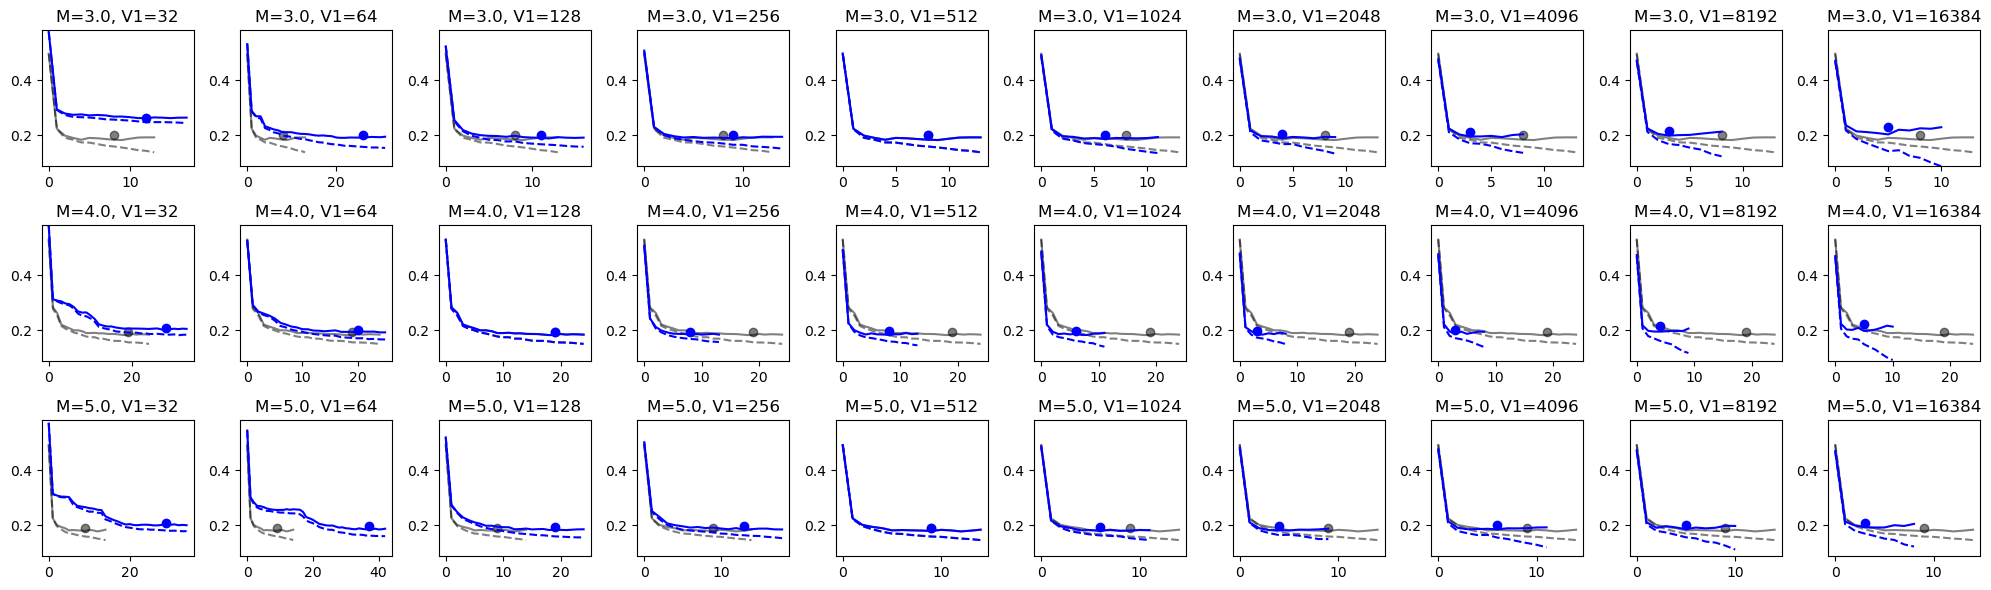

In [12]:
metric = "losses"
metric = "viol"

min_loss = min(min(r["train_"+metric] + r["val_"+metric]) for r in results)
max_loss = max(max(r["train_"+metric] + r["val_"+metric]) for r in results)

xvar = 'v1_neurons'
yvar = 'margin'
xvar2 = 'V1'
yvar2 = 'M'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))
nx = len(xvals)
ny = len(yvals)


plt.figure(figsize=(nx*2,ny*2))
ip = 0

for yval in yvals:
    

    #ed = hyper_params[model_id]["embedding dim"]
    for xval in xvals:

        ip += 1
        plt.subplot(ny,nx,ip)
        
        #xval = hyper_params[model_id]["margin"]
        model_id = next(r["model id"] for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)


        hyper_p = f"{yvar2}={yval}, {xvar2}={xval}"

        best_id = best_m_id[yvals.index(yval)]
        plt.plot(results[best_id]['train_'+metric],'k--',alpha=0.5)
        plt.plot(results[best_id]['val_'+metric],'k-',alpha=0.5)
        plt.plot(results[best_id]['best_epoch'],test_results[best_id]['test_'+metric],'ko',alpha=0.5)

        plt.plot(results[model_id]['train_'+metric],'b--')
        plt.plot(results[model_id]['val_'+metric],'b-')
        plt.plot(results[model_id]['best_epoch'],test_results[model_id]['test_'+metric],'bo')
        plt.ylim(min_loss,max_loss)
        plt.title(hyper_p)
        #plt.yscale('log')
        plt.tight_layout()

In [13]:
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))
xvals, yvals

([32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384], [3.0, 4.0, 5.0])

0.20100000500679016
1.3367003927707672
0.8226591757371446


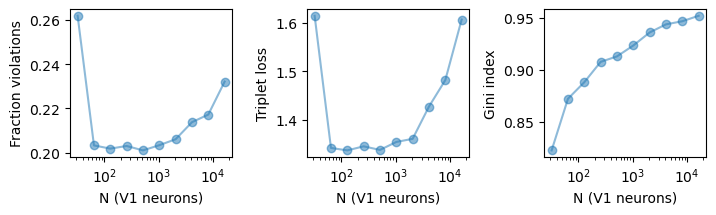

In [17]:
metric_i = ["viol","losses","gini"]
#metric = "viol"
#metric = "losses"
#metric = "gini"
mouse_exp = 20*16*16
human_exp = 300*16*16

xvar = 'v1_neurons'
yvar = 'margin'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))

# Define styles
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
yvals_to_color = {ed: colors[i % len(colors)] for i, ed in enumerate(yvals)}

# Plot
plt.figure(figsize=(12, 6))
ip = 0
for metric in metric_i:
    
    
    xval_array = np.array(xvals)

    for yval in [3.0]:
        ip += 1
        plt.subplot(3,5,ip)

        test_losses = []
        for xval in xvals:
            model_id = next(r["model id"] for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)

            test_losses.append(test_results[model_id]['test_'+metric])
        print(min(test_losses))
        color = yvals_to_color[yval]
        label = f"{yvar}={yval}"
        plt.plot(xval_array, test_losses, 'o-',label=label,alpha=0.5)
        yl = plt.ylim()  # get current y-axis limits
        #plt.plot(mouse_exp*np.ones(2), yl, '--r', linewidth=2)  # vertical line at x=3
        #plt.plot(human_exp*np.ones(2), yl, '-.g', linewidth=2)  # vertical line at x=7
        # Formatting
        plt.xscale("log")
        plt.xlabel("N (V1 neurons)")
        if metric == "viol":
            plt.ylabel("Fraction violations")
        elif metric == "losses":
            plt.ylabel("Triplet loss")
        elif metric == "gini":
            plt.ylabel("Gini index")

        
        #plt.title(label)
        #plt.legend()
        plt.tight_layout()
plt.savefig('/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/02_code/thalamocortical_powerlaw/figures/test_results_margin3.png')

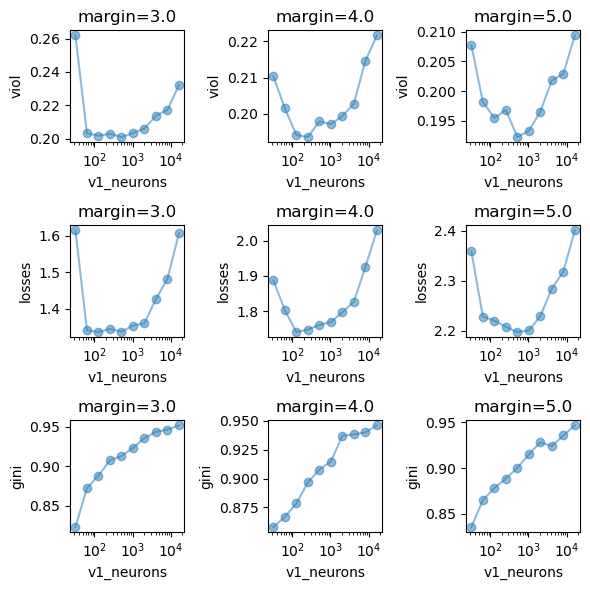

In [19]:
metric_i = ["viol","losses","gini"]
#metric = "viol"
#metric = "losses"
#metric = "gini"
mouse_exp = 20*16*16
human_exp = 300*16*16

xvar = 'v1_neurons'
yvar = 'margin'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))
nx = len(xvals)
ny = len(yvals)
nm = len(metric_i)

# Define styles
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
yvals_to_color = {ed: colors[i % len(colors)] for i, ed in enumerate(yvals)}

# Plot
plt.figure(figsize=(ny*2, nm*2))
ip = 0
for metric in metric_i:
    
    
    xval_array = np.array(xvals)

    for yval in yvals:
        ip += 1
        plt.subplot(nm,ny,ip)

        test_losses = []
        for xval in xvals:
            model_id = next(i for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)

            test_losses.append(test_results[model_id]['test_'+metric])

        color = yvals_to_color[yval]
        label = f"{yvar}={yval}"
        plt.plot(xval_array, test_losses, 'o-',label=label,alpha=0.5)
        yl = plt.ylim()  # get current y-axis limits
        #plt.plot(mouse_exp*np.ones(2), yl, '--r', linewidth=2)  # vertical line at x=3
        
        # Formatting
        plt.xscale("log")
        plt.xlabel(xvar)
        plt.ylabel(metric)
        plt.title(label)
        #plt.legend()
        plt.tight_layout()
plt.savefig(f'/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/02_code/thalamocortical_powerlaw/figures/test_results_{data_name}.png')

In [20]:
def rearrange_blocks_fixed(blocks, p, q):
    m, n1, n2 = blocks.shape
    assert n1 == n2, "Blocks must be square"
    assert m == p * q, "m must equal p * q"
    n = n1
    reshaped = blocks.reshape(p, q, n, n)
    merged = reshaped.swapaxes(1, 2).reshape(p * n, q * n)
    return merged

In [21]:
def gaussian_kernel2d(kernel_size=5, sigma=0.25, device='cpu'):
    ax = torch.arange(kernel_size, device=device) - kernel_size // 2
    xx, yy = torch.meshgrid(ax, ax, indexing="xy")
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

In [22]:
def resmooth_weights(model, sigma=0.25):
    weight = model.fc.weight.data
    emb_dim = weight.shape[0]
    weight_reshaped = weight.view(emb_dim, 1, 16, 16)

    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel2d(kernel_size, sigma, device=weight.device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)

    smoothed = F.conv2d(weight_reshaped, kernel, padding=kernel_size // 2)
    model.fc.weight.data.copy_(smoothed.view(emb_dim, -1))

In [23]:
# Load best model
weights_reshaped = []
for model_id in range(n_models):

    ed = hyper_params[model_id]["v1_neurons"]

    margin = hyper_params[model_id]["margin"]
    margin_str = f"{margin:.1f}".replace('.', 'p')
    model_file = f"{models_path}/class_{data_name}_weights_M{margin_str}_V1{ed}_EP{epochs}.pt"
    model = LGN2V1(input_dim=256, output_dim=ed)
    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()

    # ---- Smooth the weights again ----
    resmooth_weights(model, sigma=.5)

    # Extract weights from first layer (input to hidden): shape (n_hidden_units, 256)
    first_layer = model.fc  # Replace if you used a different name
    weights = first_layer.weight.detach().cpu().numpy()  # shape: (n_hidden_units, 256)

    # Reshape to (n_hidden_units, 16, 16)
    weights_reshaped.append(weights.reshape(weights.shape[0], 16, 16))

    print("Weight shape:", weights_reshaped[model_id].shape)  # (n_hidden_units, 16, 16)

Weight shape: (32, 16, 16)
Weight shape: (32, 16, 16)
Weight shape: (32, 16, 16)
Weight shape: (64, 16, 16)
Weight shape: (64, 16, 16)
Weight shape: (64, 16, 16)
Weight shape: (128, 16, 16)
Weight shape: (128, 16, 16)
Weight shape: (128, 16, 16)
Weight shape: (256, 16, 16)
Weight shape: (256, 16, 16)
Weight shape: (256, 16, 16)
Weight shape: (512, 16, 16)
Weight shape: (512, 16, 16)
Weight shape: (512, 16, 16)
Weight shape: (1024, 16, 16)
Weight shape: (1024, 16, 16)
Weight shape: (1024, 16, 16)
Weight shape: (2048, 16, 16)
Weight shape: (2048, 16, 16)
Weight shape: (2048, 16, 16)
Weight shape: (4096, 16, 16)
Weight shape: (4096, 16, 16)
Weight shape: (4096, 16, 16)
Weight shape: (8192, 16, 16)
Weight shape: (8192, 16, 16)
Weight shape: (8192, 16, 16)
Weight shape: (16384, 16, 16)
Weight shape: (16384, 16, 16)
Weight shape: (16384, 16, 16)


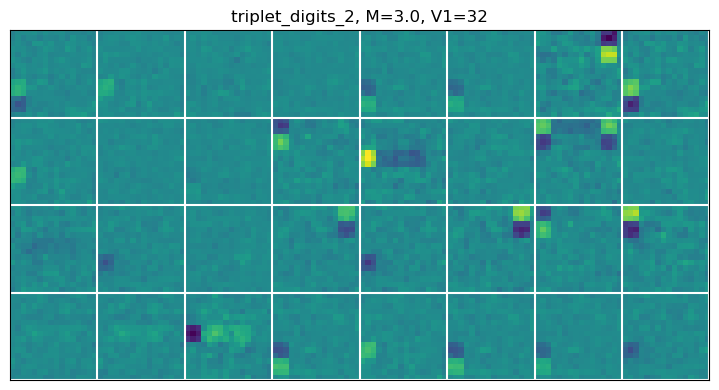

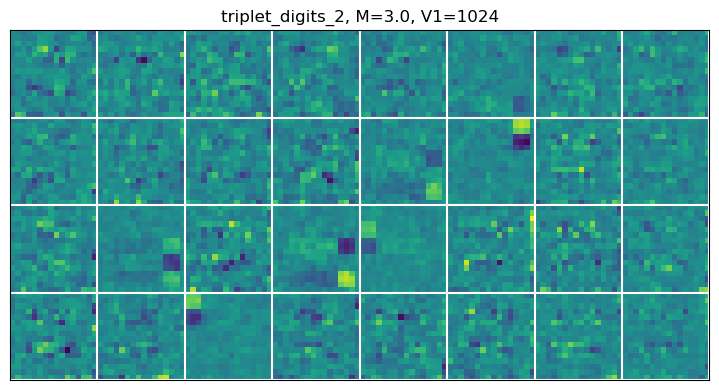

In [25]:
n = 16
p = 4 # rows 
q = 8 # columns
size_factor = 1.
for hp in hyper_params:
    model_id = hp["model id"]
    
    embedding_dim = hyper_params[model_id]['v1_neurons']
    margin = hyper_params[model_id]['margin']
    # ---- Filter ----
    if margin != 3.0 or embedding_dim not in [32, 1024]:
        continue  # skip models that don't match criteria
    
    merged_rf = rearrange_blocks_fixed(weights_reshaped[model_id][:32,:,:], p=p, q=q)
    plt.figure(figsize=(q*size_factor,p*size_factor))
    plt.imshow(merged_rf)
    for i in range(q+1):
        plt.plot(i*n*np.ones(2)-0.5,np.array([0,n*p])-0.5,'w')
    for i in range(p+1):
        plt.plot(np.array([0,n*q])-0.5,i*n*np.ones(2)-0.5,'w')
    plt.xticks([])
    plt.yticks([])
    embedding_dim = hyper_params[model_id]['v1_neurons']
    margin = hyper_params[model_id]['margin']
    #lambda_str = "0" if l1_lambda == 0 else f"{l1_lambda:.0e}".replace('-', 'm')
    plt.title(f"{data_name}, M={margin}, V1={embedding_dim}")
    
    plt.tight_layout()
    margin_str = f"{margin:.1f}".replace('.', 'p')
    plt.savefig(f'/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/02_code/thalamocortical_powerlaw/figures/RF_class_{data_name}_M{margin_str}_V1{embedding_dim}.png')

In [26]:
margin = 3.
ed = 1024

model_id = next(r["model id"] for i, r in enumerate(hyper_params)
                if r["v1_neurons"] == ed and
                r["margin"] == margin)
print(model_id)
print(emb_act[model_id].shape)

ed = 32
model_id_32 = next(r["model id"] for i, r in enumerate(hyper_params)
                if r["v1_neurons"] == ed and
                r["margin"] == margin)
print(model_id_32)
print(emb_act[model_id_32].shape)

15
(20000, 1024)
0
(20000, 32)


In [27]:
triplet_data, labels = u.load_mat("/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/digits/triplet_digits_2.mat", "triplets")

In [28]:
# ---- Example dataset with data and labels ----
# triplet_data: Tensor of shape [N, 3, 16, 16]
# labels:       Numpy array of length N (integer labels)
N = len(triplet_data)
labels = np.array(labels[0,:])  # Make sure you have labels aligned with triplet_data

# ---- Create random permutation of indices ----
indices = torch.randperm(N)
train_size = int(0.7 * N)
val_size = int(0.1 * N)
test_size = N - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# ---- Split dataset ----
train_data = Subset(triplet_data, train_idx)
val_data = Subset(triplet_data, val_idx)
test_data = Subset(triplet_data, test_idx)

# ---- Save label splits ----
train_labels = labels[train_idx.numpy()]
val_labels = labels[val_idx.numpy()]
test_labels = labels[test_idx.numpy()]

# ---- Create DataLoaders ----
batch_size = 128
train_loader = DataLoader(TripletDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TripletDataset(val_data), batch_size=batch_size)
test_loader = DataLoader(TripletDataset(test_data), batch_size=batch_size)

In [29]:
print(triplet_data[test_idx, 0, :, :].shape)

torch.Size([20000, 16, 16])


In [30]:
# Extract anchors (only channel 0)
anchors = triplet_data[test_idx, 0, :, :]  # shape: (20000, 16, 16)

# Flatten to 20000 x 256 safely
anchors_flat = anchors.reshape(anchors.size(0), -1)  # or use .contiguous().view(...)

# Convert to NumPy
anchors_np = anchors_flat.numpy()
print("Shape:", anchors_np.shape)  # (20000, 256)

np.save(f'/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/anchors_data_{data_name}.npy',anchors_np)

Shape: (20000, 256)


In [31]:
epochs = hyper_params[model_id]["epochs"]
np.savez(f"/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/emb_act_data_{data_name}_EP{epochs}.npz", **{f"arr_{i}": arr for i, arr in enumerate(emb_act)})

In [32]:

np.save(f'/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/test_labels_{data_name}.npy', test_labels)
test_labels.shape

(20000,)

In [33]:
# --- Fit PCA ---
pca0 = PCA(n_components=2)  # 2D projection
pca0.fit(anchors_np)  # shape: (20000, 2)
anchors_pca = pca0.transform(anchors_np)  # shape: (20000, 2)

# --- Explained variance ---
print("Explained variance ratio:", pca0.explained_variance_ratio_)
print("Total variance explained:", pca0.explained_variance_ratio_.sum())


# --- Fit PCA ---
pca32 = PCA(n_components=2)  # 2D projection
pca32.fit(emb_act[model_id_32])  # shape: (20000, 2)
emb_pca32 = pca32.transform(emb_act[model_id_32])  # shape: (20000, 2)

# --- Explained variance ---
print("Explained variance ratio:", pca32.explained_variance_ratio_)
print("Total variance explained:", pca32.explained_variance_ratio_.sum())

# --- Fit PCA ---
pca = PCA(n_components=2)  # 2D projection
pca.fit(emb_act[model_id])  # shape: (20000, 2)
emb_pca = pca.transform(emb_act[model_id])  # shape: (20000, 2)

# --- Explained variance ---
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.21057798 0.17793684]
Total variance explained: 0.38851482
Explained variance ratio: [0.1322428  0.12260715]
Total variance explained: 0.25484994
Explained variance ratio: [0.08918533 0.07872257]
Total variance explained: 0.1679079


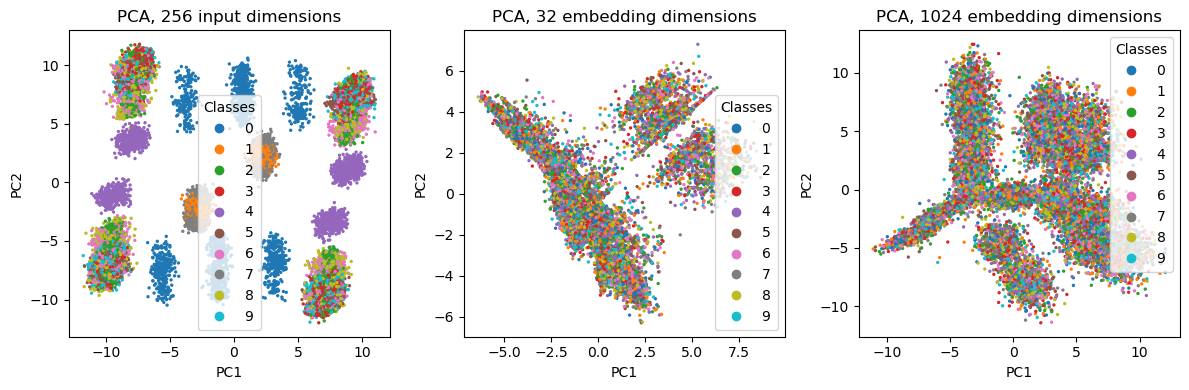

In [37]:
# --- Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
scatter = plt.scatter(anchors_pca[:, 0], anchors_pca[:, 1], 
                      c=test_labels, cmap="tab10", s=2)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA, 256 input dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

plt.subplot(1,3,2)
scatter = plt.scatter(emb_pca32[:, 0], emb_pca32[:, 1], 
                      c=test_labels, cmap="tab10", s=2)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA, 32 embedding dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

plt.subplot(1,3,3)
scatter = plt.scatter(emb_pca[:, 0], emb_pca[:, 1], 
                      c=test_labels, cmap="tab10", s=2)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA, 1024 embedding dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

plt.savefig(f'/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/02_code/thalamocortical_powerlaw/figures/PCA_{data_name}_M{margin_str}_V1{ed}_legend.png')

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [39]:
def create_split_indices(n_samples, val_size=0.2, test_size=0.2, random_state=42):
    # First split train+val and test
    train_val_idx, test_idx = train_test_split(np.arange(n_samples),
                                               test_size=test_size,
                                               random_state=random_state,
                                               shuffle=True)
    # Split train and val
    train_idx, val_idx = train_test_split(train_val_idx,
                                          test_size=val_size/(1-test_size),
                                          random_state=random_state,
                                          shuffle=True)
    return train_idx, val_idx, test_idx

# Example usage:
N = len(labels)  # number of samples
train_idx, val_idx, test_idx = create_split_indices(N)

In [40]:
class LinearSoftmax(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)  # softmax handled by loss function

In [41]:
def train_softmax_classifier_pre_split(X_train, y_train, X_val, y_val,
                                       lr=1e-3, weight_decay=1e-3,
                                       epochs=2000, patience=20):
    """
    Train a linear softmax classifier using pre-split data.
    """
    # ---- Ensure tensors and correct dtypes ----
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    else:
        X_train = X_train.float()

    if not isinstance(X_val, torch.Tensor):
        X_val = torch.tensor(X_val, dtype=torch.float32)
    else:
        X_val = X_val.float()

    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.long)
    else:
        y_train = y_train.long()

    if not isinstance(y_val, torch.Tensor):
        y_val = torch.tensor(y_val, dtype=torch.long)
    else:
        y_val = y_val.long()

    # ---- Model, Loss, Optimizer ----
    model = LinearSoftmax(X_train.shape[1], len(torch.unique(y_train)))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ---- Tracking ----
    history = {
        "val_loss": [], "val_acc": [],
        "train_loss": [], "train_acc": []
    }
    
    best_val_loss = float('inf')
    best_state = None
    wait = 0

    for epoch in range(epochs):
        # --- Train ---
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
        train_pred = outputs.argmax(dim=1)
        train_acc = (train_pred == y_train).float().mean().item()

        # --- Validation ---
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_pred = val_outputs.argmax(dim=1)
            val_acc = (val_pred == y_val).float().mean().item()

        # ---- Store metrics ----
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping ---
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [42]:
def evaluate_model(model, X_test, y_test):
    """
    Compute test loss and accuracy for a trained model.
    """
    # Ensure correct tensor types
    if not isinstance(X_test, torch.Tensor):
        X_test = torch.tensor(X_test, dtype=torch.float32)
    else:
        X_test = X_test.float()

    if not isinstance(y_test, torch.Tensor):
        y_test = torch.tensor(y_test, dtype=torch.long)
    else:
        y_test = y_test.long()

    criterion = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test).item()
        preds = outputs.argmax(dim=1)
        acc = (preds == y_test).float().mean().item()

    return loss, acc

In [43]:
# Convert to tensors
X1 = torch.tensor(anchors_np, dtype=torch.float32)  # shape: (20000, 256)
X2a = torch.tensor(emb_act[model_id_32], dtype=torch.float32)  # shape: (20000, 1024)
X2 = torch.tensor(emb_act[model_id], dtype=torch.float32)  # shape: (20000, 1024)
y = torch.tensor(test_labels, dtype=torch.long)         # shape: (20000,)

train_idx, val_idx, test_idx = create_split_indices(n_samples=20000, val_size=0.2,
                                                    test_size=0.2, random_state=42)

X1_train, X1_val, X1_test = X1[train_idx], X1[val_idx], X1[test_idx]
X2a_train, X2a_val, X2a_test = X2a[train_idx], X2a[val_idx], X2a[test_idx]
X2_train, X2_val, X2_test = X2[train_idx], X2[val_idx], X2[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

In [44]:
# Suppose A and B are PyTorch tensors or datasets
len_A, len_B = 12000, 4000

# Index vectors for A and B
indices_A = torch.arange(len_A)
indices_B = torch.arange(len_B)

sizes_A = [120,1200,12000]
sizes_B = [40,400,4000]

model1_i = []
model2a_i = []
model2_i = []

for size_A, size_B in zip(sizes_A, sizes_B):
    idx_A = indices_A[:size_A]  # take first size_A samples of A
    idx_B = indices_B[:size_B]  # take first size_B samples of B
    
    # Train on one dataset (e.g., X1)
    model1, history1 = train_softmax_classifier_pre_split(X1_train[idx_A], y_train[idx_A],
                                                          X1_val[idx_B], y_val[idx_B])
    model1_i.append(model1)
    print()
    
    # Train on another dataset (e.g., X2)
    model2a, history2 = train_softmax_classifier_pre_split(X2a_train[idx_A], y_train[idx_A],
                                                          X2a_val[idx_B], y_val[idx_B])
    model2a_i.append(model2a)
    print()
    
    # Train on another dataset (e.g., X2)
    model2, history2 = train_softmax_classifier_pre_split(X2_train[idx_A], y_train[idx_A],
                                                          X2_val[idx_B], y_val[idx_B])
    model2_i.append(model2)
    print()

Early stopping at epoch 75

Early stopping at epoch 863

Early stopping at epoch 21

Epoch 1000/2000, Train Loss: 2.2458, Train Acc: 0.2100, Val Loss: 2.3303, Val Acc: 0.1575
Epoch 2000/2000, Train Loss: 2.2067, Train Acc: 0.2733, Val Loss: 2.3271, Val Acc: 0.1775

Epoch 1000/2000, Train Loss: 2.3749, Train Acc: 0.1108, Val Loss: 2.3982, Val Acc: 0.0825
Epoch 2000/2000, Train Loss: 2.3205, Train Acc: 0.1133, Val Loss: 2.3650, Val Acc: 0.0850

Early stopping at epoch 269

Epoch 1000/2000, Train Loss: 2.2998, Train Acc: 0.1732, Val Loss: 2.3119, Val Acc: 0.1605
Epoch 2000/2000, Train Loss: 2.2909, Train Acc: 0.1968, Val Loss: 2.3062, Val Acc: 0.1850

Epoch 1000/2000, Train Loss: 2.3830, Train Acc: 0.0984, Val Loss: 2.3766, Val Acc: 0.1110
Epoch 2000/2000, Train Loss: 2.3403, Train Acc: 0.1008, Val Loss: 2.3396, Val Acc: 0.1015

Epoch 1000/2000, Train Loss: 2.3031, Train Acc: 0.1142, Val Loss: 2.3186, Val Acc: 0.1032
Epoch 2000/2000, Train Loss: 2.2951, Train Acc: 0.1244, Val Loss: 2.3168

In [45]:
test_acc1_i = []
test_acc2a_i = []
test_acc2_i = []
for i in range(3):
    test_loss1, test_acc1 = evaluate_model(model1_i[i], X1_test, y_test)
    print(f"Dataset X1 - Test Loss: {test_loss1:.4f}, Test Accuracy: {test_acc1:.4f}")
    test_acc1_i.append(test_acc1)
    # Train on another dataset (e.g., X2)
    test_loss2a, test_acc2a = evaluate_model(model2a_i[i], X2a_test, y_test)
    print(f"Dataset X2 - Test Loss: {test_loss2a:.4f}, Test Accuracy: {test_acc2a:.4f}")
    test_acc2a_i.append(test_acc2a)
    
    test_loss2, test_acc2 = evaluate_model(model2_i[i], X2_test, y_test)
    print(f"Dataset X2 - Test Loss: {test_loss2:.4f}, Test Accuracy: {test_acc2:.4f}")
    test_acc2_i.append(test_acc2)
    print()

Dataset X1 - Test Loss: 2.4218, Test Accuracy: 0.1187
Dataset X2 - Test Loss: 2.4556, Test Accuracy: 0.1080
Dataset X2 - Test Loss: 2.3600, Test Accuracy: 0.1065

Dataset X1 - Test Loss: 2.3176, Test Accuracy: 0.1855
Dataset X2 - Test Loss: 2.3624, Test Accuracy: 0.0995
Dataset X2 - Test Loss: 2.3266, Test Accuracy: 0.1045

Dataset X1 - Test Loss: 2.3036, Test Accuracy: 0.1835
Dataset X2 - Test Loss: 2.3475, Test Accuracy: 0.0983
Dataset X2 - Test Loss: 2.3140, Test Accuracy: 0.1080



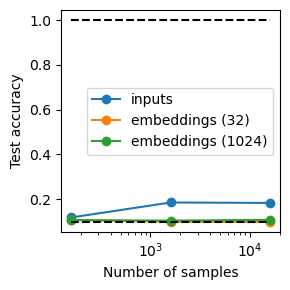

In [46]:
num_samples = [160,1600,16000]
plt.figure(figsize=(3,3))
plt.plot(num_samples,test_acc1_i,'o-',label='inputs')
plt.plot(num_samples,test_acc2a_i,'o-',label='embeddings (32)')
plt.plot(num_samples,test_acc2_i,'o-',label='embeddings (1024)')
plt.plot(num_samples,np.ones(3),'k--')
plt.plot(num_samples,0.1*np.ones(3),'k--')
plt.xlabel("Number of samples")
plt.ylabel("Test accuracy")
plt.xscale("log")
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/test_accuracy_{data_name}_M{margin_str}_V1{ed}.pdf')